<h3>Regularised regression</h3>
<p>Our original squared loss function in matrix/vector notation is:
$$ L = \frac{1}{N}\sum_{n=1}^N (\mathbf{t} - \mathbf{X}\mathbf{w})^T(\mathbf{t} - \mathbf{X}\mathbf{w}) $$
Here's another loss function:
$$ L = \lambda \mathbf{w}^T\mathbf{w} + \frac{1}{N}\sum_{n=1}^N (\mathbf{t} - \mathbf{X}\mathbf{w})^T(\mathbf{t} - \mathbf{X}\mathbf{w}) $$
Recall that we're minimising this function and so (if $\lambda>0$) this additional term will penalise large positive and negative values in $\mathbf{w}$. $\lambda$ controls how much influence this new term has over the original squared error term.</p>

<p>Differentiating this with respect to $\mathbf{w}$ and then setting to zero (this is a good exercise to do) results in:
$$ (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})\mathbf{w} = \mathbf{X}^T\mathbf{t} $$
where $\mathbf{I}$ is a square matrix with ones on the diagonal and zeros elsewhere (the identity matrix).</p>

<p>To demonstrate the effect of this additional term, we will generate some synthetic data by using a quadratic function and assing some random (normal / Gaussian) noise.</p>

lampda 0 Mean Square Error = 0.223480575369
lampda 0.01 Mean Square Error = 0.233248626626
lampda 0.02 Mean Square Error = 0.238444290646
lampda 0.04 Mean Square Error = 0.244910826995
lampda 0.08 Mean Square Error = 0.251326923632
lampda 0.16 Mean Square Error = 0.255929947365
lampda 0.32 Mean Square Error = 0.257959899459
lampda 0.64 Mean Square Error = 0.258487108554
lampda 1.28 Mean Square Error = 0.260936238138


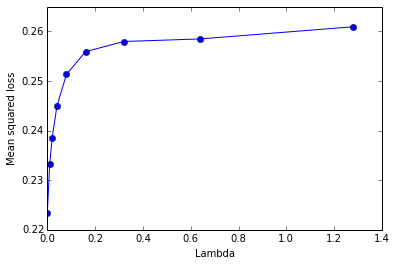

In [13]:
import urllib
urllib.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', 'winequality-red.csv')
import numpy as np
with open('winequality-red.csv') as f:
    lines = (line for line in f)
    data = np.loadtxt(lines, delimiter=';', skiprows=1)
%matplotlib inline
import pylab as plt
from numpy.linalg import inv

#np.random.shuffle(data)
N = data.shape[0] #get tupple (numRows, numCols)

train = data[:int(N*0.7)]
test = data[int(N*0.7):]
X_train = train[:,:11]
X_train = np.c_[np.ones(train.shape[0]), X_train] # append 1s as first column
q_train = train[:,11]

X_test = test[:,:11]
X_test = np.c_[np.ones(test.shape[0]), X_test]
q_test = test[:,11]

lambs = [0,0.01,0.02,0.04,0.08,0.16,0.32,0.64, 1.28]
errors = []
for lamb in lambs:
    XtX = np.dot(X_train.T, X_train)
    XtXlam = XtX + X_train.shape[0]*lamb*np.identity(12)
    XtXlamI = inv(XtXlam)
    XtXIXt = np.dot(XtXlamI, X_train.T)
    w = np.dot(XtXIXt, q_train)
    
#     w = np.linalg.solve(np.dot(X_train.T,X_train) + lamb*np.identity(12),np.dot(X_train.T,q_train))
    f_test = np.dot(X_test,w)
    meanSquareError = ((q_test-f_test)**2).mean()/2.0
#     meanSquareError = (sum((q_test-f_test)**2) + lamb*np.dot(w.T,w))/float(2*X_test.shape[0])
    #print meanSquareError
    errors += [meanSquareError]
    print "lampda", lamb, "Mean Square Error =", meanSquareError
    #plt.figure()
    #plt.scatter(f_test,q_test, color='blue')

plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Mean squared loss')
plt.plot(lambs, errors, '-o')


<p>As $\lambda$ increases, high values in $\mathbf{w}$ are more heavily penalised which leads to *simpler* functions. Why do lower values correspond to simpler functions?</p>
<p>Firstly, what does *simpler* mean?</p>
<p>I would argue that simpler functions have smaller derivatives (first, second, etc) as they typically change more slowly. In our polynomials, the derivatives are dependent on the values of $\mathbf{w}$. In particular our polynomial is:
$$ t = \sum_{d=0}^D w_d x^d $$
and the first derivative is:
$$ \frac{dt}{dx} = \sum_{d=1}^D dw_d x^{d-1} $$
and second is:
$$ \frac{d^2t}{dx^2} = \sum_{d=2}^D d(d-1)w_d x^{d-2} $$
which in both cases increases with increasing values of $w_d$. So penalising high (positive and negative) values decreases (in general) the gradients (and gradients of gradients, etc).</p> 

Mean cv_loss error 0.187886244788
Mean train_loss 0.202688764111
Mean ind_loss 0.220361053166


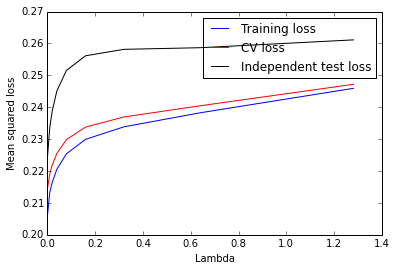

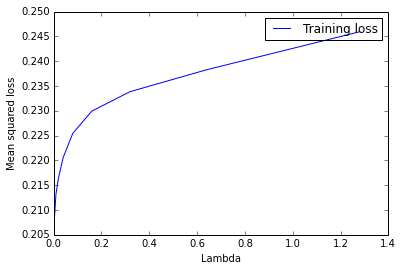

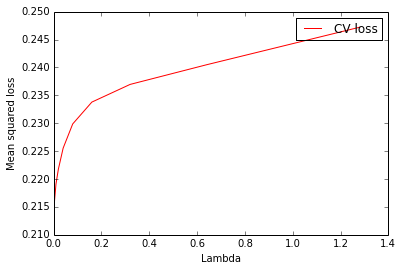

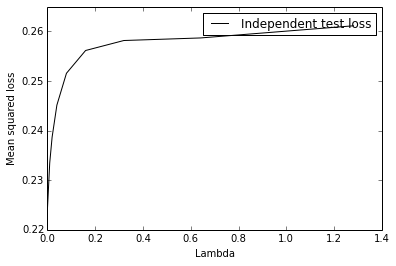

In [12]:
N = train.shape[0]
K = 10
sizes = np.tile(np.floor(N/10),(1,K))
sizes[-1] = sizes[-1] + N - sizes.sum()
c_sizes = np.hstack((0,np.cumsum(sizes)))
X = np.copy(train[:,:11])
X = np.c_[np.ones(train.shape[0]), X]
t = np.copy(train[:,11])
X_test = np.copy(test[:,:11])
X_test = np.c_[np.ones(test.shape[0]), X_test]
t_test = np.copy(test[:,11])
lambs = [0,0.01,0.02,0.04,0.08,0.16,0.32,0.64, 1.28]
cv_loss = np.zeros((K, len(lambs)))
ind_loss = np.zeros((K, len(lambs)))
train_loss = np.zeros((K, len(lambs)))

k = 0
for lamb in lambs:
    for fold in range(K):
        X_fold = X[c_sizes[fold]:c_sizes[fold+1],:]
        X_train = np.delete(X,np.arange(c_sizes[fold],c_sizes[fold+1],1),0)

        t_fold = t[c_sizes[fold]:c_sizes[fold+1]]
        t_train = np.delete(t,np.arange(c_sizes[fold],c_sizes[fold+1],1),0)
        XtX = np.dot(X_train.T, X_train)
        XtXlam = XtX + X_train.shape[0]*lamb*np.identity(12)
        XtXlamI = inv(XtXlam)
        XtXIXt = np.dot(XtXlamI, X_train.T)
        w = np.dot(XtXIXt, t_train)
        
#         w = np.linalg.solve(np.dot(X_train.T,X_train) + lamb*np.identity(12),np.dot(X_train.T,t_train))
        fold_pred = np.dot(X_fold,w)
        cv_loss[fold,k] = ((fold_pred - t_fold)**2).mean()/2.0
        ind_pred = np.dot(X_test,w)
        ind_loss[fold,k] = ((ind_pred - t_test)**2).mean()/2.0
        train_pred = np.dot(X_train,w)
        train_loss[fold,k] = ((train_pred - t_train)**2).mean()/2.0
        
#         cv_loss[fold,k] = (sum((fold_pred-t_fold)**2) + lamb*np.dot(w.T,w))/float(2*X_fold.shape[0])
#         ind_pred = np.dot(X_test,w)
#         ind_loss[fold,k] = (sum((ind_pred-t_test)**2) + lamb*np.dot(w.T,w))/float(2*X_test.shape[0])
#         train_pred = np.dot(X_train,w)
#         train_loss[fold,k] = (sum((train_pred-t_train)**2) + lamb*np.dot(w.T,w))/float(2*X_train.shape[0])
    k += 1

print "Mean cv_loss error", cv_loss.min()
print "Mean train_loss", train_loss.min()
print "Mean ind_loss", ind_loss.min()
plt.figure()
plt.plot(lambs,train_loss.mean(axis=0),'b-',label="Training loss")
plt.plot(lambs,cv_loss.mean(axis=0),'r-',label="CV loss")
plt.plot(lambs,ind_loss.mean(axis=0),'k',label="Independent test loss")
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Mean squared loss')

plt.figure()
plt.plot(lambs,train_loss.mean(axis=0),'b-',label="Training loss")
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Mean squared loss')
plt.figure()
plt.plot(lambs,cv_loss.mean(axis=0),'r-',label="CV loss")
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Mean squared loss')
plt.figure()
plt.plot(lambs,ind_loss.mean(axis=0),'k',label="Independent test loss")
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Mean squared loss')

In [15]:
a = np.array([[2,4,6],[9,0,1]])
print a.mean(axis=0)

[ 5.5  2.   3.5]


In [18]:
b = np.array([ 0.38944992,  0.27887931,  0.50708128,  0.49355501,  0.48526273])
np.argmin(b)

1